In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import random


dropout_rate = 0.2
DATA_DIR = f'results_005_lang_id_classification_dropout_{dropout_rate}'



random.seed(42)
# COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
COLORS = ["#7f7f7f", "#1f77b4"]

n = 84
n_train = int(np.ceil(n * .6))
n_test = n - n_train


In [2]:
data_frames = {}

variable_names = []

for model_path in Path(DATA_DIR).iterdir():
    if not model_path.is_dir():
        continue
        
    if "NN" not in str(model_path):
        continue
    
    model_name = model_path.stem
    print(f"MODEL: {model_name}")
    fold_names = []
    
    data_frames[model_name] = {}
    
    for p in Path(model_path).iterdir():
        if p.suffixes[-1] != '.csv':
            continue
        fold_name = p.stem
        fold_names.append(fold_name)
        data_frames[model_name][fold_name] = pd.read_csv(p)
        variable_names.extend(list(data_frames[model_path.stem][p.stem].columns))
    for fold_name in sorted(fold_names):
        print(f"\t{fold_name}")

print(f"VARIABLES")        
for variable_name in sorted(set(variable_names)):
    print(f"\t{variable_name}")
        
    

MODEL: LangIdCNN_Mean1
	retrained-wav2vec_features-c_0
	retrained-wav2vec_features-c_1
	retrained-wav2vec_features-c_2
	retrained-wav2vec_features-c_3
	retrained-wav2vec_features-c_4
	retrained-wav2vec_features-c_5
	retrained-wav2vec_features-c_6
	retrained-wav2vec_features-c_7
	retrained-wav2vec_features-c_8
	retrained-wav2vec_features-c_9
	retrained-wav2vec_features-z_0
	retrained-wav2vec_features-z_1
	retrained-wav2vec_features-z_2
	retrained-wav2vec_features-z_3
	retrained-wav2vec_features-z_4
	retrained-wav2vec_features-z_5
	retrained-wav2vec_features-z_6
	retrained-wav2vec_features-z_7
	retrained-wav2vec_features-z_8
	retrained-wav2vec_features-z_9
	wav2vec_features-c_0
	wav2vec_features-c_1
	wav2vec_features-c_2
	wav2vec_features-c_3
	wav2vec_features-c_4
	wav2vec_features-c_5
	wav2vec_features-c_6
	wav2vec_features-c_7
	wav2vec_features-c_8
	wav2vec_features-c_9
	wav2vec_features-z_0
	wav2vec_features-z_1
	wav2vec_features-z_2
	wav2vec_features-z_3
	wav2vec_features-z_4
	wav2ve

In [3]:
def get_variable_stats(model_name, feature_prefix, variable, sample_size):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
    
    m = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    
    
    
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    if variable == 'test_acc':
        print(f"{model_name}, {feature_prefix} {variable}, max-mean: {np.max(m)}, max-max: {np.max(maximum)}")
        # print(f"{model_name}, {feature_prefix} {variable}, max: {np.max(m_max)}, min {np.min(m_min)}")
        max_per_fold = np.max(data, axis=(0))
        print(np.mean(max_per_fold))
        
    return data, m, sem, minimum, maximum
    
        

In [4]:
def get_variable_stats(model_name, feature_prefix, variable, sample_size, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
        best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    
    #
    # Stats of the variable @best epoch for each fold
    #
    ep_best = np.argmax(best_epoch_selection_data, axis=0)
    
    # value of the variable for the best epoch of each fold
    ep_best_values = [data[ep_best[fold_ix], fold_ix] for fold_ix in range(len(ep_best))]
    ep_best_mean = np.mean(ep_best_values)
    ep_best_sem = np.std(ep_best_values) / np.sqrt(sample_size)
    ep_best_min = np.min(ep_best_values)
    ep_best_max = np.max(ep_best_values)
    
    
    #
    # Stats of the variable @each epoch
    #
    mean = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    stats = {
        'data': data,
        'epochs_mean': mean,
        'epochs_sem': sem,
        'epochs_min': minimum,
        'epochs_max': maximum,
        
        'best_epoch_mean': ep_best_mean,
        'best_epoch_sem': ep_best_sem,
        'best_epoch_min': ep_best_min,
        'best_epoch_max': ep_best_max
    }
    
    #if variable == 'test_acc':
    #    print(f"{model_name}, {feature_prefix} {variable}")
    #    [print(f"max {k}", np.max(v)) for k,v in stats.items() if k != 'data']
        
    return stats

In [5]:
def plot_comparative_variables(ax, model_name, feature_prefixes, variable, sample_size):
    line_styles = ['-', '-']
    for index, feature_prefix in enumerate(feature_prefixes):
        stats = get_variable_stats(model_name, feature_prefix, variable, sample_size)
        
        x = range(1, stats['data'].shape[0]+1)

        ax.plot(x, stats['epochs_mean'], color=COLORS[index], linestyle=line_styles[index], label=f'{model_name} {feature_prefix}', alpha=1)
        
        ax.fill_between(
            x, 
            stats['epochs_mean'] + stats['epochs_sem'], 
            stats['epochs_mean'] - stats['epochs_sem'], 
            color=COLORS[index], alpha=0.6
        )
        
        ax.fill_between(
            x, 
            stats['epochs_min'], 
            stats['epochs_max'], 
            color=COLORS[index], alpha=0.1
        )

    ax.grid(True)
    ax.title.set_text(variable)
    ax.legend()

In [6]:
def plot_results(model_names, variables_and_sample_sizes, compared_features):
    variables = [t[0] for t in variables_and_sample_sizes]
    sample_sizes_by_variable = {t[0]:t[1] for t in variables_and_sample_sizes}

    plot_width = len(model_names)*10
    plot_height = len(variables)*10
    fig, axes = plt.subplots(len(variables), len(model_names), sharex=True, sharey='row', figsize=(plot_width, plot_height))
    for variable_index, variable in enumerate(variables):
        # fig, axes = plt.subplots(1, len(model_names), sharex=True, sharey=True, figsize=(20, 7))
        sample_size = sample_sizes_by_variable[variable]
        for model_index, model_name in enumerate(model_names):
            plot_comparative_variables(
                axes[variable_index, model_index],
                model_name,
                compared_features,
                variable,
                sample_size
            )

In [7]:
# def plot_best_results(model_names, variables_and_sample_sizes, model_selection_variable, compared_features):
    

In [8]:
model_names = ['LangIdCNN_Mean1', 'LangIdCNN_Std1', 'LangIdCNN_Mean2', 'LangIdCNN_Std2']
fold_count = 10

#variables_and_sample_sizes = [
#    ('train_loss', n_train),
#    ('test_loss', n_test),
#    ('train_acc', n_train),
#    ('test_acc', n_test),
#    ('test_acc_gender_male', n_test),
#    ('test_acc_gender_female', n_test),
#    ('test_acc_language_maninka', n_test),
#    ('test_acc_language_pular', n_test),
#    ('test_acc_language_susu', n_test)
#]


variables_and_sample_sizes = [
    ('train_loss', fold_count),
    ('test_loss', fold_count),
    ('train_acc', fold_count),
    ('test_acc', fold_count),
    ('test_acc_gender_male', fold_count),
    ('test_acc_gender_female', fold_count),
    ('test_acc_language_maninka', fold_count),
    ('test_acc_language_pular', fold_count),
    ('test_acc_language_susu', fold_count)
]


# Language classification with context features

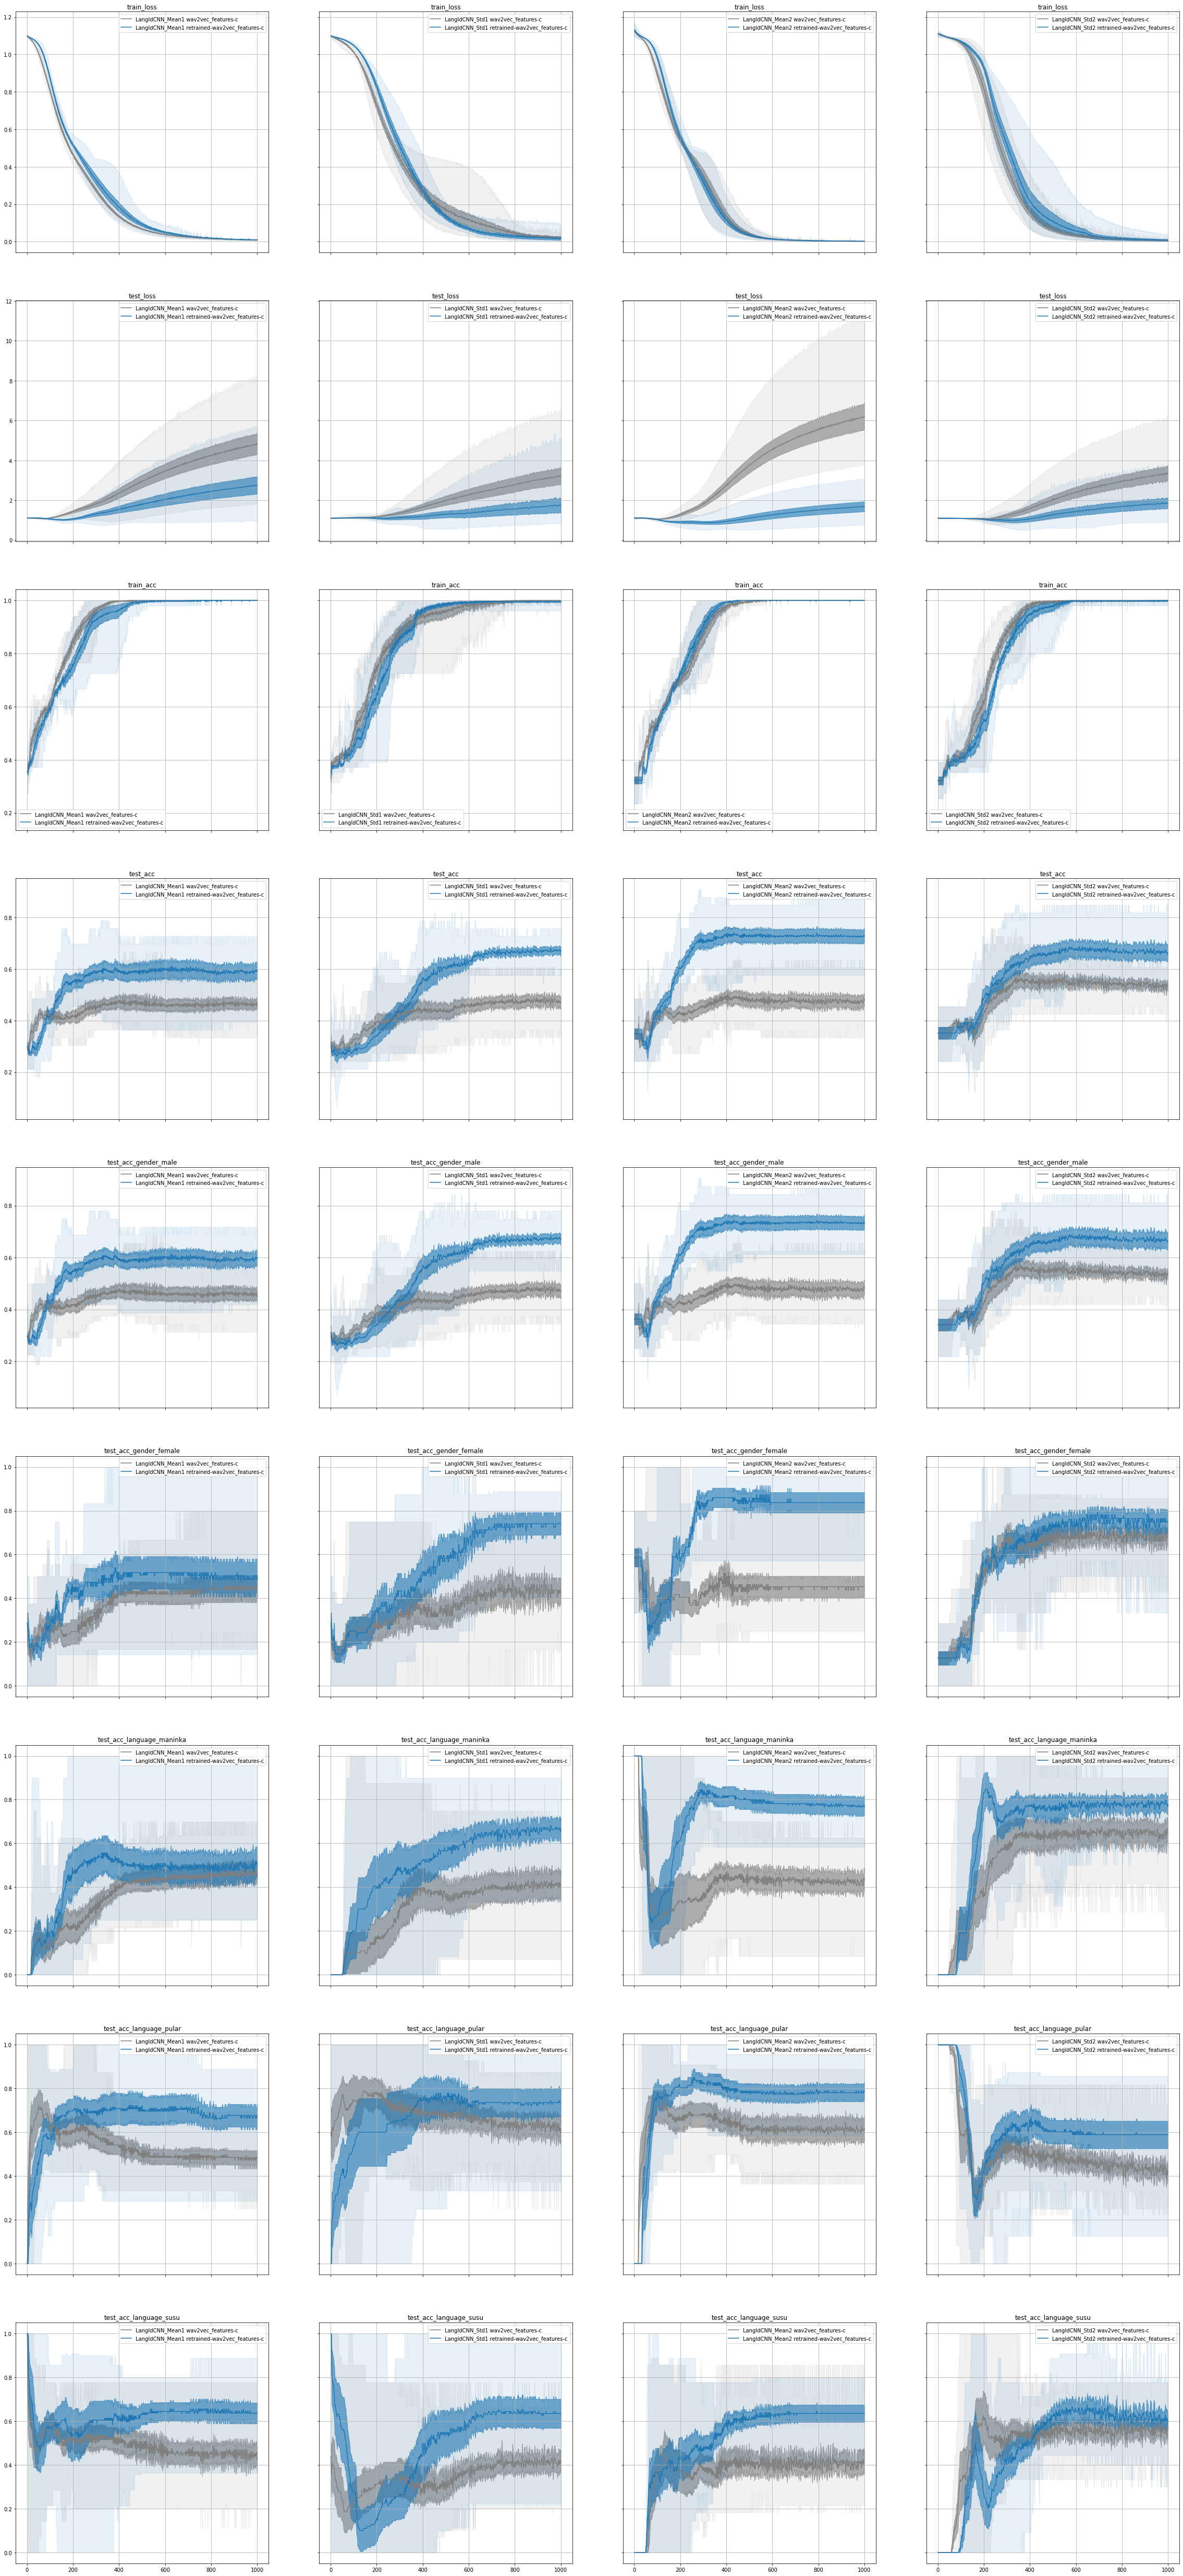

In [9]:
compared_features = ['wav2vec_features-c', 'retrained-wav2vec_features-c']
plot_results(model_names, variables_and_sample_sizes, compared_features)

# Language Classification With Latent Features

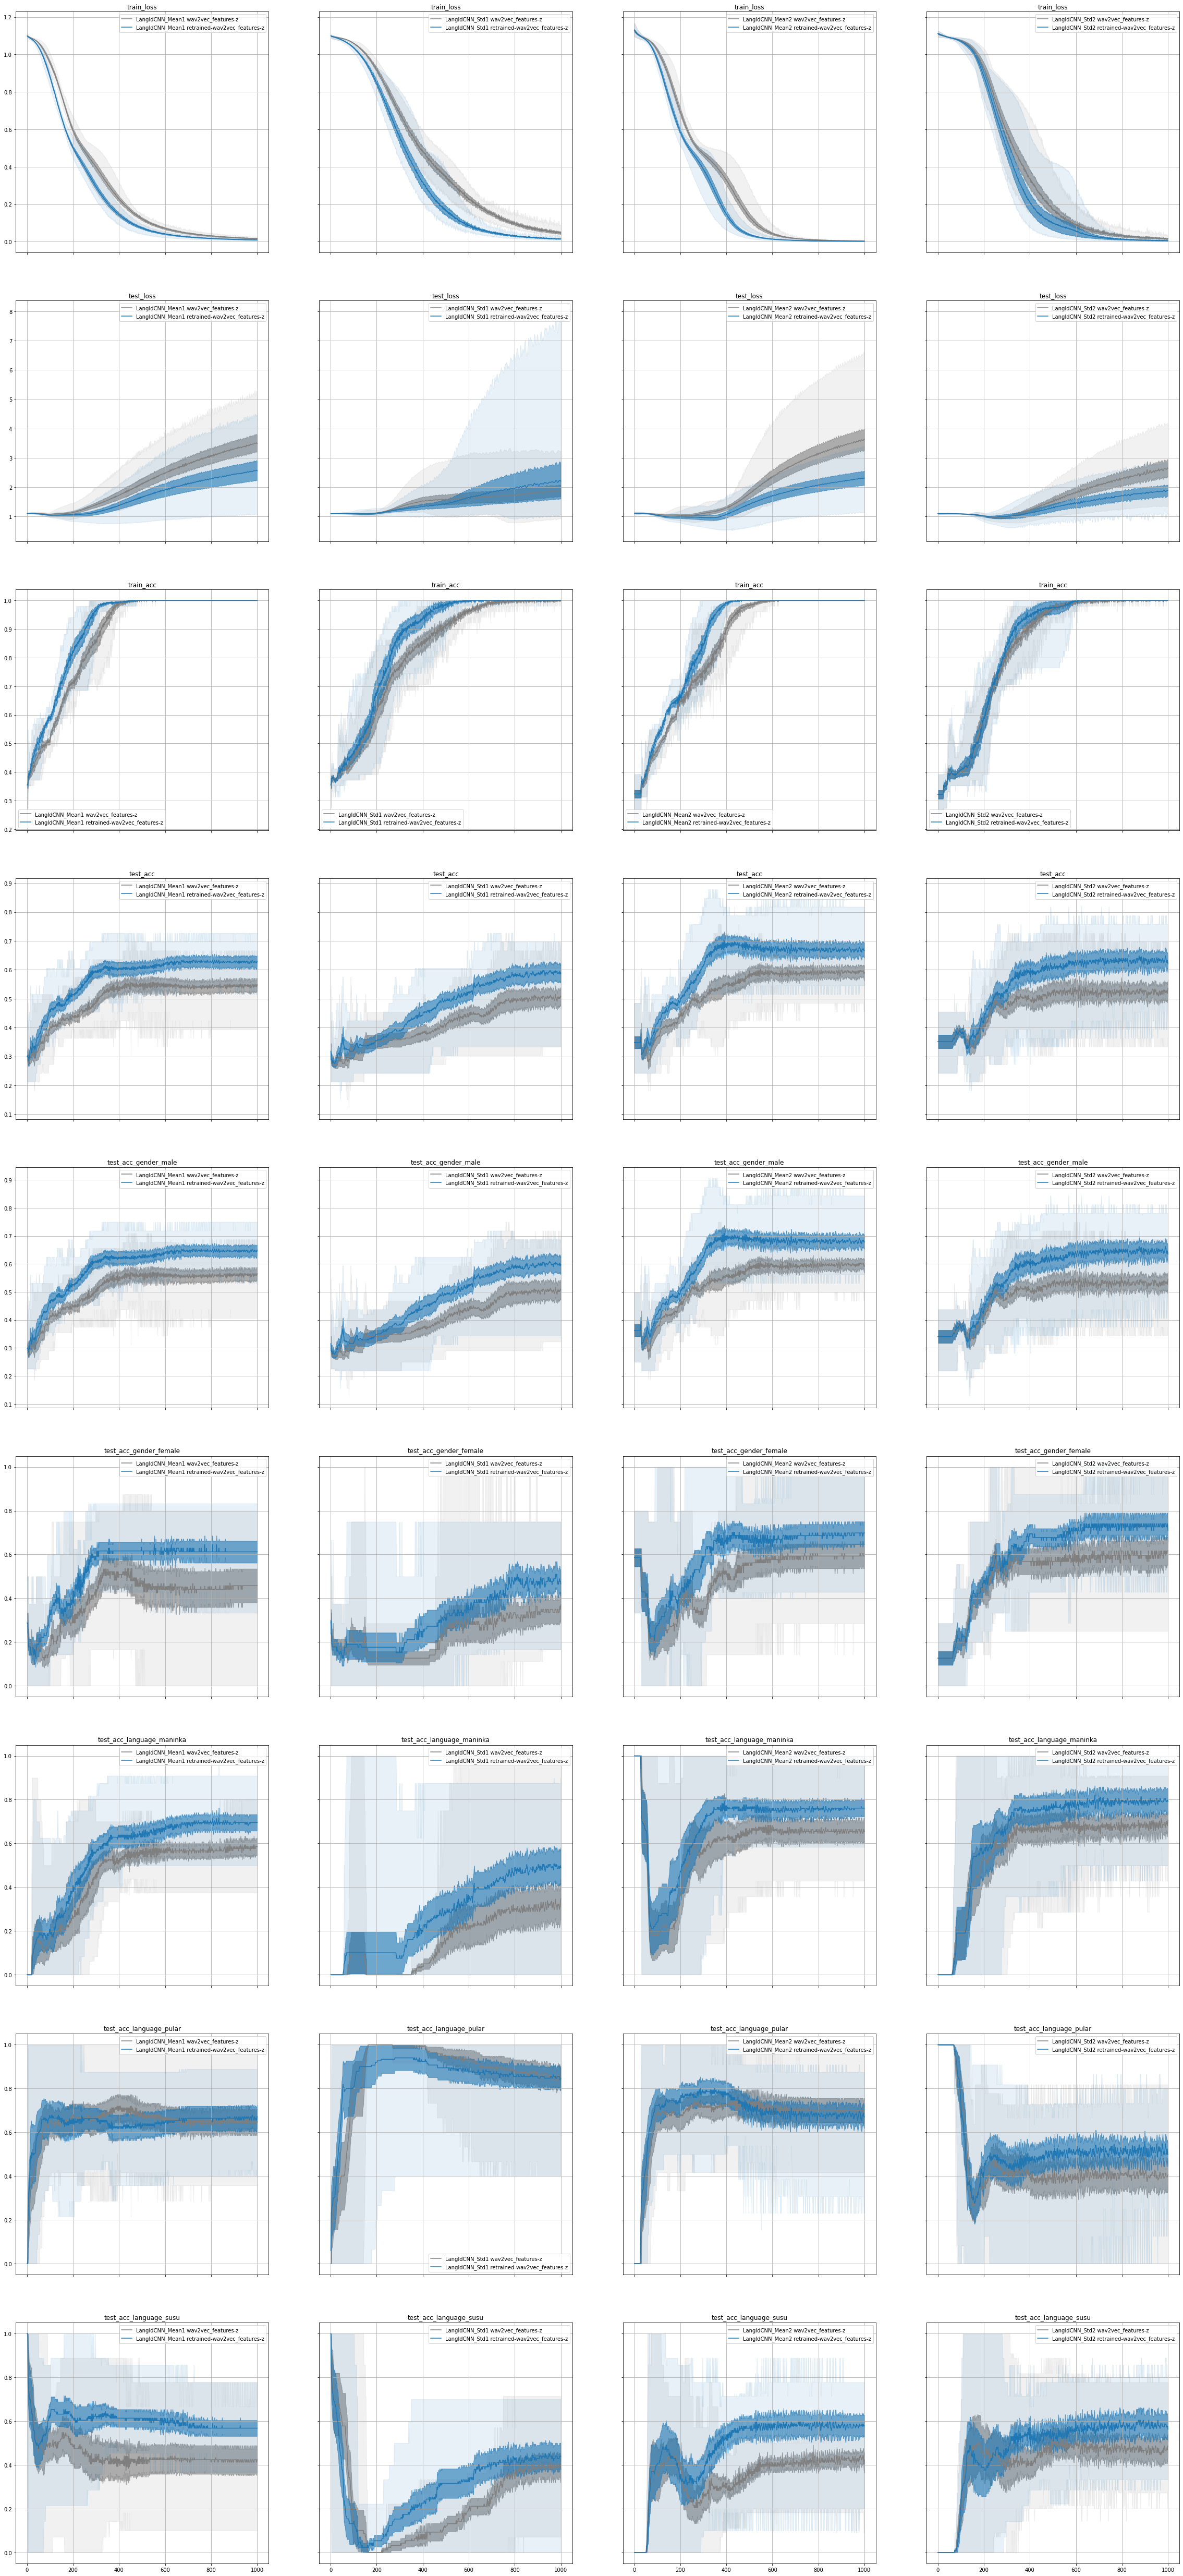

In [10]:
compared_features = ['wav2vec_features-z', 'retrained-wav2vec_features-z']
plot_results(model_names, variables_and_sample_sizes, compared_features)

# Best epoch summaries

In [11]:
def make_label_str(model_name, feature_name):
    m_name = model_name.replace('LangId','')# .replace("1", "")

    f_name = feature_name.replace(
        "retrained-wav2vec_features-z", "OUR  Latent"
    ).replace(
        "retrained-wav2vec_features-c", "OUR  Context"
    ).replace(
        "wav2vec_features-z", "BSLN  Latent"
    ).replace(
        "wav2vec_features-c", "BSLN  Context"
    )


    # return m_name, f_name
    return f"{f_name} - {m_name}"

In [12]:
def plot_summary_results(model_names, variables_and_sample_sizes, compared_features):
    variables = [t[0] for t in variables_and_sample_sizes]
    sample_sizes_by_variable = {t[0]:t[1] for t in variables_and_sample_sizes}
    
    series_means = {v:[] for v in variables}
    series_sems = {v:[] for v in variables}
    series_mins = {v:[] for v in variables}
    series_maxes = {v:[] for v in variables}
    
    series_labels = {v:[] for v in variables}
    
    for variable in variables:
        for feature_prefix in compared_features:
            sample_size = sample_sizes_by_variable[variable]
            for model_name in model_names:
                stats = get_variable_stats(model_name, feature_prefix, variable, sample_size)
                series_means[variable].append(stats['best_epoch_mean'])
                series_sems[variable].append(stats['best_epoch_sem'])
                series_mins[variable].append(stats['best_epoch_min'])
                series_maxes[variable].append(stats['best_epoch_max'])
                series_labels[variable].append((model_name, feature_prefix))
    
    for v in variables:
        df = pd.DataFrame(
            data={
                f'{v}_labels': [make_label_str(l[0], l[1]) for l in series_labels[v]],
                f'{v}_means': series_means[v],
                f'{v}_sems': series_sems[v],
            }
        )
        display(df)
    
    # Variables
    # 'train_loss', 'test_loss', 
    # 'train_acc', 'test_acc', 
    # 'test_acc_gender_male', 'test_acc_gender_female', 
    # 'test_acc_language_maninka', 'test_acc_language_pular', 'test_acc_language_susu'
    
    fig, ax = plt.subplots(figsize=(15, 10))
    #plt.bar(labels, mean_train_acc)
    #print(labels)
    bar_width = 5
    bar_margin = 10
    
    label_count = len(series_labels['test_acc'])
    
    colors = {
        "male": "#58508d",
        "female": "#ff6361",
        "maninka": "#88290d",
        "susu": "#b44f0f",
        "pular": "#dc790b",
        "train": "#7f7f7f",
        "test":"#4682b4"
    }
#88290d

#b44f0f

#dc790b

    train_y_pos = (bar_width+bar_margin)*np.arange(label_count)
    test_y_pos =(bar_width+bar_margin)*np.arange(label_count)
    test_y_male_pos =(bar_width+bar_margin)*np.arange(label_count) + 3.5
    test_y_female_pos =(bar_width+bar_margin)*np.arange(label_count) + 4.5
    
    test_y_susu_pos =(bar_width+bar_margin)*np.arange(label_count) + 6
    test_y_maninka_pos =(bar_width+bar_margin)*np.arange(label_count) + 7
    test_y_pular_pos =(bar_width+bar_margin)*np.arange(label_count) + 8
    

    ax.barh(train_y_pos, series_means['train_acc'], height=5, xerr=series_sems['train_acc'], color=colors['train'])
    ax.barh(test_y_pos, series_means['test_acc'], height=5, xerr=series_sems['test_acc'], color=colors['test']) # color=COLORS[2]
    
    bias_alpha = 0.6
    ax.barh(test_y_male_pos, series_means['test_acc_gender_male'], height=1, xerr=series_sems['test_acc_gender_male'], color=colors['male'], alpha=bias_alpha)
    ax.barh(test_y_female_pos, series_means['test_acc_gender_female'], height=1, xerr=series_sems['test_acc_gender_female'], color=colors['female'], alpha=bias_alpha)
    
    ax.barh(test_y_susu_pos, series_means['test_acc_language_susu'], height=1, xerr=series_sems['test_acc_language_susu'], color=colors['susu'], alpha=bias_alpha)
    ax.barh(test_y_maninka_pos, series_means['test_acc_language_maninka'], height=1, xerr=series_sems['test_acc_language_maninka'], color=colors['maninka'], alpha=bias_alpha)
    ax.barh(test_y_pular_pos, series_means['test_acc_language_pular'], height=1, xerr=series_sems['test_acc_language_pular'], color=colors['pular'], alpha=bias_alpha)
    
    for i, label in enumerate(series_labels['test_acc']):
        (model_name, feature_name) = label

        
        
        label_str = make_label_str(model_name, feature_name)

        train_acc_label_str = f"{series_means['train_acc'][i]:.02%}"
        test_acc_label_str = f"{series_means['test_acc'][i]:.02%}"

        ax.text(0.01, train_y_pos[i], label_str, color='white', fontsize="x-large", fontweight="bold")

        ax.text(series_means['train_acc'][i]-0.07, train_y_pos[i]-0.7, train_acc_label_str, color='white', fontsize="large")
        ax.text(series_means['test_acc'][i]-0.07, train_y_pos[i]-0.7, test_acc_label_str, color='white', fontsize="large")
        
        
        ax.text(0.01, test_y_male_pos[i]-0.3, "male", color='black', fontsize="small")
        ax.text(0.01, test_y_female_pos[i]-0.3, "female", color='black', fontsize="small")
        
        ax.text(0.01, test_y_susu_pos[i]-0.3, "susu", color='black', fontsize="small")
        ax.text(0.01, test_y_maninka_pos[i]-0.3, "maninka", color='black', fontsize="small")
        ax.text(0.01, test_y_pular_pos[i]-0.3, "pular", color='black', fontsize="small")
        
        
        ax.legend(["TRAIN", "TEST", "TEST (Male)", "TEST (Female)", "TEST (Susu)", "TEST (Maninka)", "TEST (Pular)"])
        ax.set_xlim(0, 1)
        ax.get_yaxis().set_ticks([])
        ax.set_title(f"Average and SEM (n=10 folds) Language Identification Accuracies. Dropout p={dropout_rate}")
        ax.grid(True)

        
        


train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Latent - CNN_Mean1          0.215059         0.042272
1   OUR  Latent - CNN_Mean1          0.192070         0.072752

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Latent - CNN_Mean1         1.845857        0.175363
1   OUR  Latent - CNN_Mean1         1.570981        0.205426

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Latent - CNN_Mean1         0.960784        0.022356
1   OUR  Latent - CNN_Mean1         0.949020        0.030779

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Latent - CNN_Mean1        0.590909       0.018803
1   OUR  Latent - CNN_Mean1        0.654545       0.015570

test_acc_gender_male_labels  test_acc_gender_male_means  \
0    BSLN  Latent - CNN_Mean1                    0.605847   
1     OUR  Latent - CNN_Mean1                    0.671673   

   test_acc_gender_male_sems  
0                   0.019166  
1                   0.016557

test_acc_gender_female_labels  test_acc_gender_female_means  \
0      BSLN  Latent - CNN_Mean1                      0.574960   
1       OUR  Latent - CNN_Mean1                      0.633056   

   test_acc_gender_female_sems  
0                     0.070882  
1                     0.039149

test_acc_language_maninka_labels  test_acc_language_maninka_means  \
0         BSLN  Latent - CNN_Mean1                         0.628220   
1          OUR  Latent - CNN_Mean1                         0.659021   

   test_acc_language_maninka_sems  
0                        0.034010  
1                        0.038357

test_acc_language_pular_labels  test_acc_language_pular_means  \
0       BSLN  Latent - CNN_Mean1                       0.727319   
1        OUR  Latent - CNN_Mean1                       0.706843   

   test_acc_language_pular_sems  
0                      0.050055  
1                      0.045704

test_acc_language_susu_labels  test_acc_language_susu_means  \
0      BSLN  Latent - CNN_Mean1                      0.437605   
1       OUR  Latent - CNN_Mean1                      0.644603   

   test_acc_language_susu_sems  
0                     0.071469  
1                     0.044402

train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Context - CNN_Mean1          0.491377         0.121153
1   OUR  Context - CNN_Mean1          0.348985         0.065034

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Context - CNN_Mean1         1.685299        0.230502
1   OUR  Context - CNN_Mean1         1.183040        0.091481

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Context - CNN_Mean1         0.815686        0.064510
1   OUR  Context - CNN_Mean1         0.878431        0.038001

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Context - CNN_Mean1        0.548485       0.024033
1   OUR  Context - CNN_Mean1        0.663636       0.031623

test_acc_gender_male_labels  test_acc_gender_male_means  \
0   BSLN  Context - CNN_Mean1                    0.545161   
1    OUR  Context - CNN_Mean1                    0.655343   

   test_acc_gender_male_sems  
0                   0.027033  
1                   0.031663

test_acc_gender_female_labels  test_acc_gender_female_means  \
0     BSLN  Context - CNN_Mean1                      0.449881   
1      OUR  Context - CNN_Mean1                      0.604325   

   test_acc_gender_female_sems  
0                     0.035845  
1                     0.064504

test_acc_language_maninka_labels  test_acc_language_maninka_means  \
0        BSLN  Context - CNN_Mean1                         0.429827   
1         OUR  Context - CNN_Mean1                         0.528755   

   test_acc_language_maninka_sems  
0                        0.067526  
1                        0.087028

test_acc_language_pular_labels  test_acc_language_pular_means  \
0      BSLN  Context - CNN_Mean1                       0.675540   
1       OUR  Context - CNN_Mean1                       0.801685   

   test_acc_language_pular_sems  
0                      0.056579  
1                      0.049547

test_acc_language_susu_labels  test_acc_language_susu_means  \
0     BSLN  Context - CNN_Mean1                      0.586349   
1      OUR  Context - CNN_Mean1                      0.703824   

   test_acc_language_susu_sems  
0                     0.047623  
1                     0.051625

train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Latent - CNN_Std1          0.338037         0.122968
1   OUR  Latent - CNN_Std1          0.185928         0.102553

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Latent - CNN_Std1         1.412593        0.149855
1   OUR  Latent - CNN_Std1         1.237364        0.066342

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Latent - CNN_Std1         0.849020        0.085246
1   OUR  Latent - CNN_Std1         0.923529        0.062895

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Latent - CNN_Std1        0.542424       0.029520
1   OUR  Latent - CNN_Std1        0.624242       0.024693

test_acc_gender_male_labels  test_acc_gender_male_means  \
0     BSLN  Latent - CNN_Std1                    0.542036   
1      OUR  Latent - CNN_Std1                    0.624395   

   test_acc_gender_male_sems  
0                   0.032189  
1                   0.025163

test_acc_gender_female_labels  test_acc_gender_female_means  \
0       BSLN  Latent - CNN_Std1                      0.396944   
1        OUR  Latent - CNN_Std1                      0.546984   

   test_acc_gender_female_sems  
0                     0.079733  
1                     0.048227

test_acc_language_maninka_labels  test_acc_language_maninka_means  \
0          BSLN  Latent - CNN_Std1                         0.322045   
1           OUR  Latent - CNN_Std1                         0.494962   

   test_acc_language_maninka_sems  
0                        0.095316  
1                        0.077295

test_acc_language_pular_labels  test_acc_language_pular_means  \
0        BSLN  Latent - CNN_Std1                       0.784351   
1         OUR  Latent - CNN_Std1                       0.836907   

   test_acc_language_pular_sems  
0                      0.093387  
1                      0.075721

test_acc_language_susu_labels  test_acc_language_susu_means  \
0       BSLN  Latent - CNN_Std1                      0.526681   
1        OUR  Latent - CNN_Std1                      0.554069   

   test_acc_language_susu_sems  
0                     0.091370  
1                     0.064402

train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Context - CNN_Std1          0.243912         0.062546
1   OUR  Context - CNN_Std1          0.162062         0.067596

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Context - CNN_Std1         1.756395        0.145012
1   OUR  Context - CNN_Std1         1.170641        0.137226

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Context - CNN_Std1         0.939216        0.025483
1   OUR  Context - CNN_Std1         0.972549        0.016217

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Context - CNN_Std1        0.518182       0.024033
1   OUR  Context - CNN_Std1        0.715152       0.019261

test_acc_gender_male_labels  test_acc_gender_male_means  \
0    BSLN  Context - CNN_Std1                    0.514113   
1     OUR  Context - CNN_Std1                    0.718952   

   test_acc_gender_male_sems  
0                   0.024411  
1                   0.022015

test_acc_gender_female_labels  test_acc_gender_female_means  \
0      BSLN  Context - CNN_Std1                      0.463651   
1       OUR  Context - CNN_Std1                      0.787817   

   test_acc_gender_female_sems  
0                     0.058801  
1                     0.049827

test_acc_language_maninka_labels  test_acc_language_maninka_means  \
0         BSLN  Context - CNN_Std1                         0.421953   
1          OUR  Context - CNN_Std1                         0.697413   

   test_acc_language_maninka_sems  
0                        0.077901  
1                        0.051263

test_acc_language_pular_labels  test_acc_language_pular_means  \
0       BSLN  Context - CNN_Std1                       0.731855   
1        OUR  Context - CNN_Std1                       0.787060   

   test_acc_language_pular_sems  
0                      0.061232  
1                      0.064539

test_acc_language_susu_labels  test_acc_language_susu_means  \
0      BSLN  Context - CNN_Std1                      0.457013   
1       OUR  Context - CNN_Std1                      0.683203   

   test_acc_language_susu_sems  
0                     0.058833  
1                     0.084064

train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Latent - CNN_Mean2          0.358744         0.095990
1   OUR  Latent - CNN_Mean2          0.231721         0.064724

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Latent - CNN_Mean2         1.477672        0.170927
1   OUR  Latent - CNN_Mean2         1.010992        0.100923

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Latent - CNN_Mean2         0.817647        0.068658
1   OUR  Latent - CNN_Mean2         0.941176        0.038722

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Latent - CNN_Mean2        0.636364       0.020101
1   OUR  Latent - CNN_Mean2        0.739394       0.029442

test_acc_gender_male_labels  test_acc_gender_male_means  \
0    BSLN  Latent - CNN_Mean2                    0.646371   
1     OUR  Latent - CNN_Mean2                    0.744355   

   test_acc_gender_male_sems  
0                   0.018725  
1                   0.029358

test_acc_gender_female_labels  test_acc_gender_female_means  \
0      BSLN  Latent - CNN_Mean2                      0.620952   
1       OUR  Latent - CNN_Mean2                      0.812183   

   test_acc_gender_female_sems  
0                     0.034159  
1                     0.047732

test_acc_language_maninka_labels  test_acc_language_maninka_means  \
0         BSLN  Latent - CNN_Mean2                         0.794659   
1          OUR  Latent - CNN_Mean2                         0.842890   

   test_acc_language_maninka_sems  
0                        0.050398  
1                        0.031489

test_acc_language_pular_labels  test_acc_language_pular_means  \
0       BSLN  Latent - CNN_Mean2                       0.738269   
1        OUR  Latent - CNN_Mean2                       0.785070   

   test_acc_language_pular_sems  
0                      0.036671  
1                      0.048407

test_acc_language_susu_labels  test_acc_language_susu_means  \
0      BSLN  Latent - CNN_Mean2                      0.358745   
1       OUR  Latent - CNN_Mean2                      0.599654   

   test_acc_language_susu_sems  
0                     0.057939  
1                     0.070422

train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Context - CNN_Mean2          0.535004         0.138746
1   OUR  Context - CNN_Mean2          0.309519         0.047482

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Context - CNN_Mean2         1.912958        0.357489
1   OUR  Context - CNN_Mean2         0.888906        0.097580

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Context - CNN_Mean2         0.729412        0.080788
1   OUR  Context - CNN_Mean2         0.909804        0.034767

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Context - CNN_Mean2        0.572727       0.015717
1   OUR  Context - CNN_Mean2        0.769697       0.024318

test_acc_gender_male_labels  test_acc_gender_male_means  \
0   BSLN  Context - CNN_Mean2                    0.583065   
1    OUR  Context - CNN_Mean2                    0.772177   

   test_acc_gender_male_sems  
0                   0.017195  
1                   0.022897

test_acc_gender_female_labels  test_acc_gender_female_means  \
0     BSLN  Context - CNN_Mean2                      0.614722   
1      OUR  Context - CNN_Mean2                      0.867460   

   test_acc_gender_female_sems  
0                     0.051486  
1                     0.047643

test_acc_language_maninka_labels  test_acc_language_maninka_means  \
0        BSLN  Context - CNN_Mean2                         0.718766   
1         OUR  Context - CNN_Mean2                         0.869107   

   test_acc_language_maninka_sems  
0                        0.051405  
1                        0.034936

test_acc_language_pular_labels  test_acc_language_pular_means  \
0      BSLN  Context - CNN_Mean2                       0.680812   
1       OUR  Context - CNN_Mean2                       0.849808   

   test_acc_language_pular_sems  
0                      0.058599  
1                      0.040437

test_acc_language_susu_labels  test_acc_language_susu_means  \
0     BSLN  Context - CNN_Mean2                      0.292237   
1      OUR  Context - CNN_Mean2                      0.594214   

   test_acc_language_susu_sems  
0                     0.063542  
1                     0.051541

train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Latent - CNN_Std2          0.454461         0.089088
1   OUR  Latent - CNN_Std2          0.088243         0.038881

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Latent - CNN_Std2         1.146701        0.100819
1   OUR  Latent - CNN_Std2         1.379529        0.186130

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Latent - CNN_Std2         0.833333        0.045247
1   OUR  Latent - CNN_Std2         0.978431        0.016741

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Latent - CNN_Std2        0.606061       0.020553
1   OUR  Latent - CNN_Std2        0.690909       0.027707

test_acc_gender_male_labels  test_acc_gender_male_means  \
0     BSLN  Latent - CNN_Std2                    0.615121   
1      OUR  Latent - CNN_Std2                    0.703427   

   test_acc_gender_male_sems  
0                   0.019224  
1                   0.028566

test_acc_gender_female_labels  test_acc_gender_female_means  \
0       BSLN  Latent - CNN_Std2                      0.726071   
1        OUR  Latent - CNN_Std2                      0.754683   

   test_acc_gender_female_sems  
0                     0.051667  
1                     0.047107

test_acc_language_maninka_labels  test_acc_language_maninka_means  \
0          BSLN  Latent - CNN_Std2                         0.810476   
1           OUR  Latent - CNN_Std2                         0.805119   

   test_acc_language_maninka_sems  
0                        0.046432  
1                        0.047964

test_acc_language_pular_labels  test_acc_language_pular_means  \
0        BSLN  Latent - CNN_Std2                       0.516253   
1         OUR  Latent - CNN_Std2                       0.620057   

   test_acc_language_pular_sems  
0                      0.078553  
1                      0.048268

test_acc_language_susu_labels  test_acc_language_susu_means  \
0       BSLN  Latent - CNN_Std2                      0.483853   
1        OUR  Latent - CNN_Std2                      0.634603   

   test_acc_language_susu_sems  
0                     0.070723  
1                     0.055601

train_loss_labels  train_loss_means  train_loss_sems
0  BSLN  Context - CNN_Std2          0.414971         0.091444
1   OUR  Context - CNN_Std2          0.278106         0.084969

test_loss_labels  test_loss_means  test_loss_sems
0  BSLN  Context - CNN_Std2         1.316004        0.183177
1   OUR  Context - CNN_Std2         1.163594        0.153668

train_acc_labels  train_acc_means  train_acc_sems
0  BSLN  Context - CNN_Std2         0.843137        0.056626
1   OUR  Context - CNN_Std2         0.903922        0.035883

test_acc_labels  test_acc_means  test_acc_sems
0  BSLN  Context - CNN_Std2        0.624242       0.030364
1   OUR  Context - CNN_Std2        0.727273       0.029066

test_acc_gender_male_labels  test_acc_gender_male_means  \
0    BSLN  Context - CNN_Std2                    0.629839   
1     OUR  Context - CNN_Std2                    0.731452   

   test_acc_gender_male_sems  
0                   0.032639  
1                   0.029665

test_acc_gender_female_labels  test_acc_gender_female_means  \
0      BSLN  Context - CNN_Std2                      0.612421   
1       OUR  Context - CNN_Std2                      0.768135   

   test_acc_gender_female_sems  
0                     0.079187  
1                     0.044762

test_acc_language_maninka_labels  test_acc_language_maninka_means  \
0         BSLN  Context - CNN_Std2                         0.619318   
1          OUR  Context - CNN_Std2                         0.892457   

   test_acc_language_maninka_sems  
0                        0.087721  
1                        0.023459

test_acc_language_pular_labels  test_acc_language_pular_means  \
0       BSLN  Context - CNN_Std2                       0.632749   
1        OUR  Context - CNN_Std2                       0.647108   

   test_acc_language_pular_sems  
0                      0.035623  
1                      0.060281

test_acc_language_susu_labels  test_acc_language_susu_means  \
0      BSLN  Context - CNN_Std2                      0.643506   
1       OUR  Context - CNN_Std2                      0.598398   

   test_acc_language_susu_sems  
0                     0.047239  
1                     0.066549

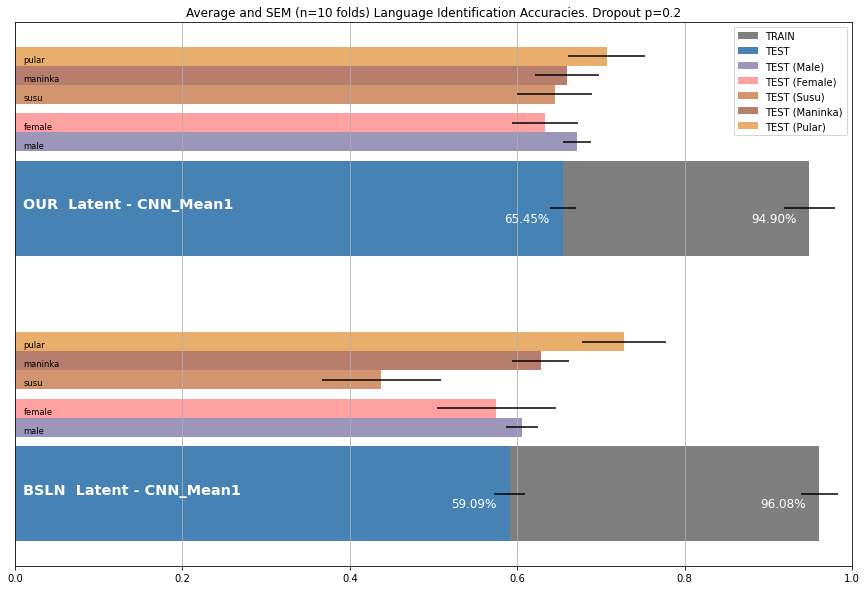

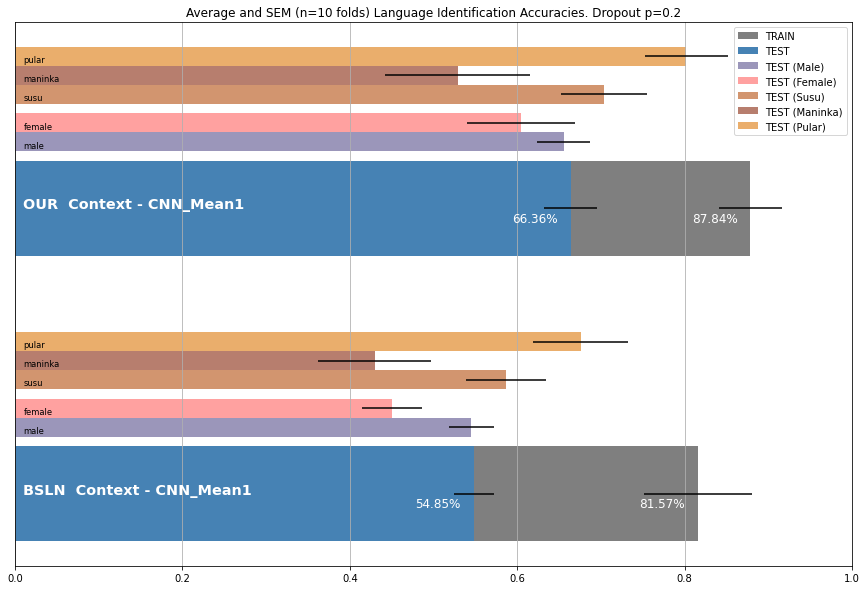

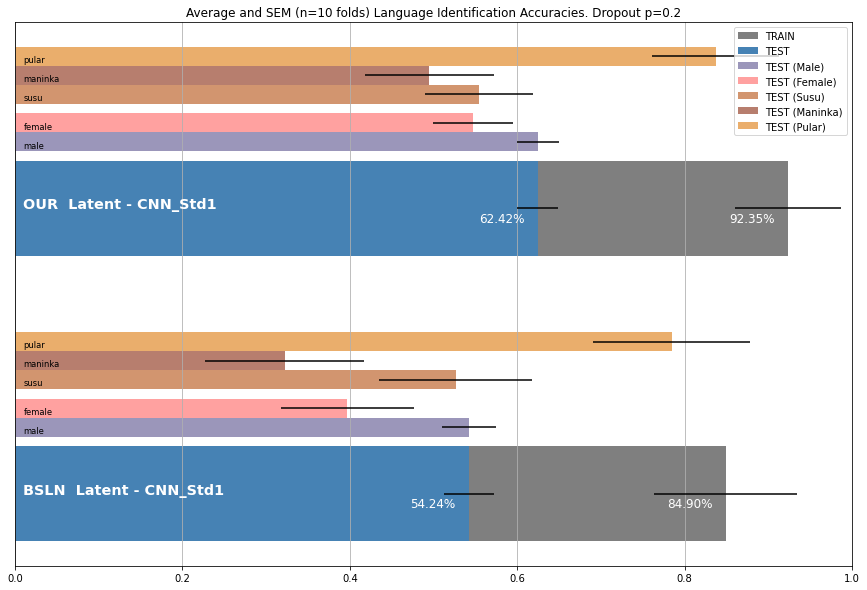

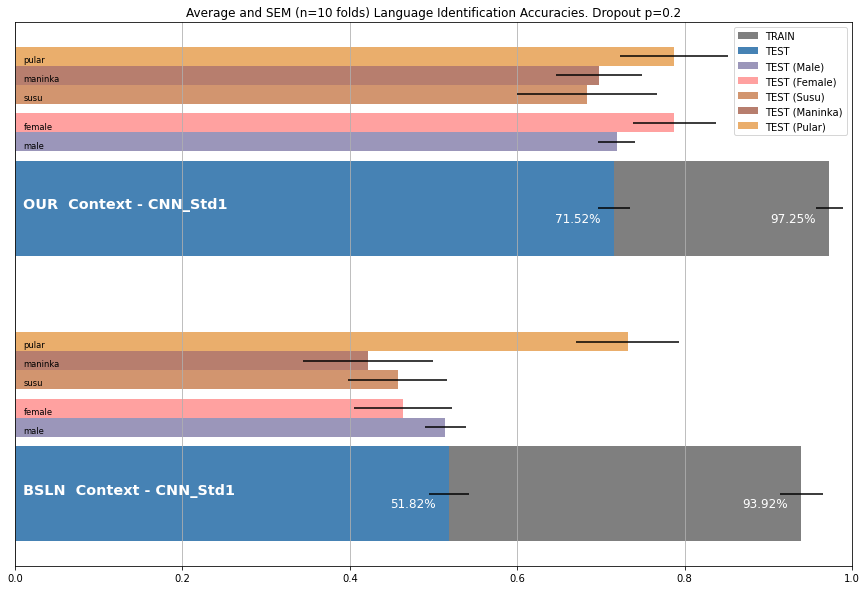

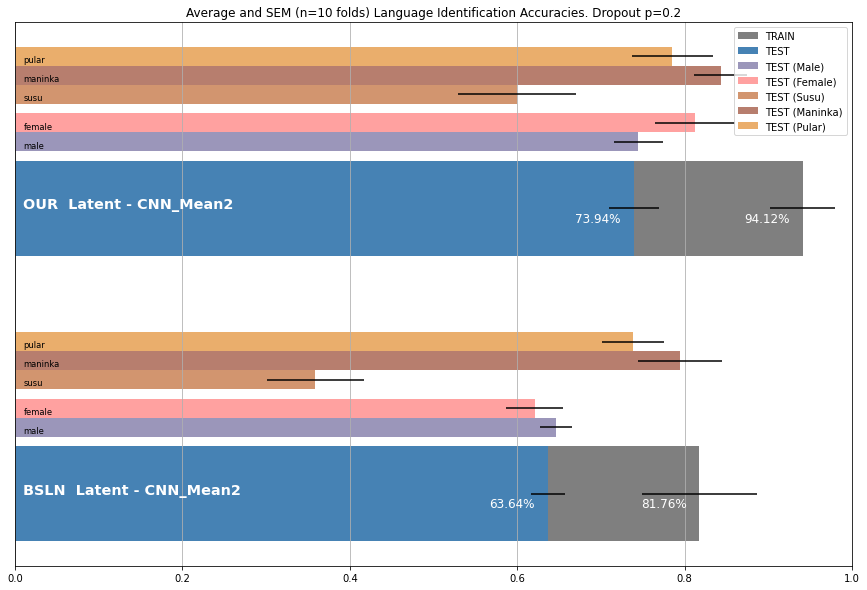

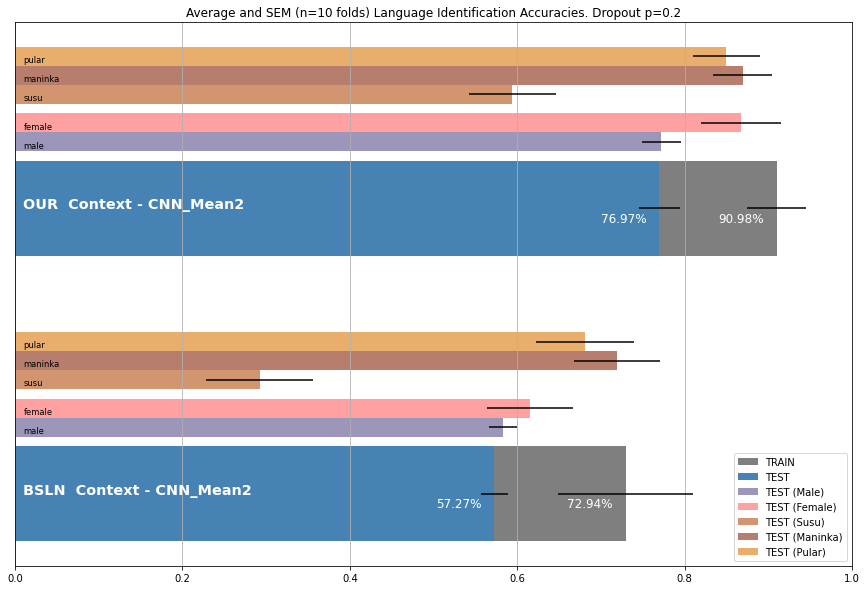

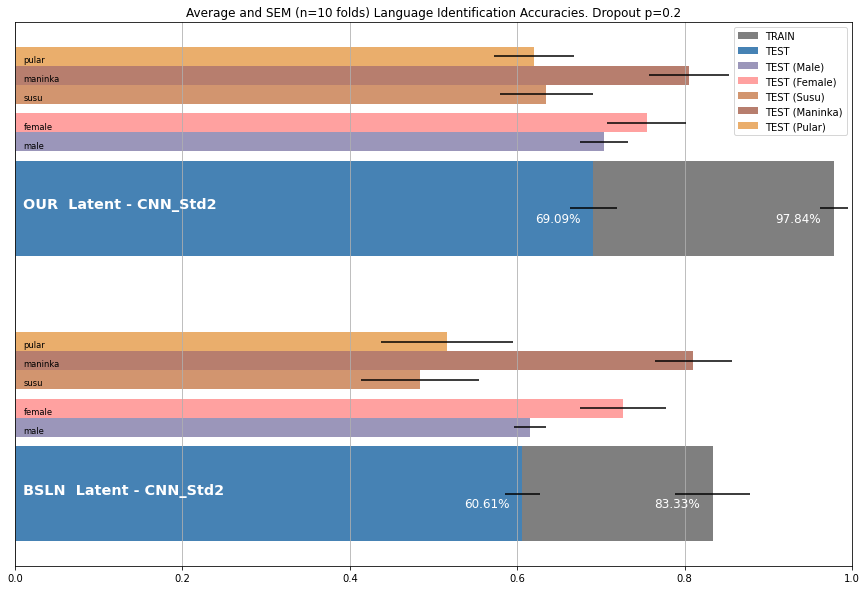

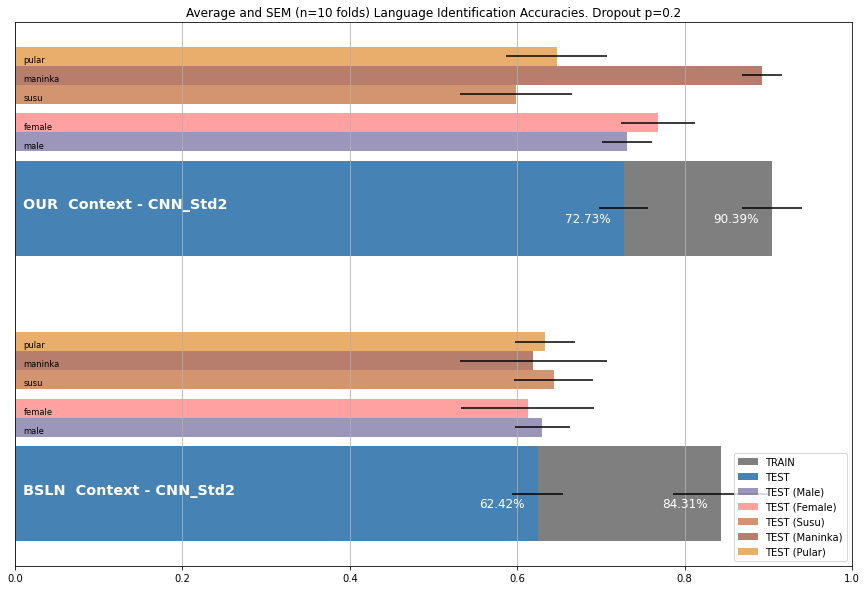

In [13]:
compared_features_latent = ['wav2vec_features-z', 'retrained-wav2vec_features-z']
compared_features_ctx = ['wav2vec_features-c', 'retrained-wav2vec_features-c']

for model_name in model_names:
    plot_summary_results([model_name], variables_and_sample_sizes, compared_features_latent)
    plot_summary_results([model_name], variables_and_sample_sizes, compared_features_ctx)
